## Transformers - Aula Prática 08/04

## Componentes essenciais

Neste notebook iremos trabalhar e entender um pouco com os componentes essencias que compõem os *Transformers*. Mais especificamente, iremos retomar alguns conceitos que vimos previamente no curso (como *skip connections*) e mais recentemente em mecanismos de *atenção*.

### Mecanismo de atenção *scaled dot-product*

Como visto em aulas passadas, existe uma infinidade de mecanismos de atenção propostos por artigos da área de processamento de linguagem natural e afins, como: *additive attention*, *deep attention*, entre outros. Porém, todos comportilham da mesma ideia de computar similaridade entre uma *query* (consulta) e uma "base de dados" (*keys*), criando assim o que é chamado de *attention weights*, que serão utilizados como pesos para uma soma ponderada de certos valores (*values*).

Uma forma natural de computar similaridade entre duas coisas é através do produto interno entre vetores. E é assim que a ideia de *dot-product attention* surge! Essa forma de atenção assume a seguinte fórmula, que recebe o nome de *self-attention*:

$$
\mathbf{Y} = \text{Softmax}[\mathbf{X} \mathbf{X^T}] \mathbf{X}
$$

Note que com essa formulação, nós não temos parâmetros aprendíveis durante a atenção, logo podemos utilizar a matriz $\mathbf{\tilde{X}} = \mathbf{XU}$ como sendo a matriz que iremos computar a atenção:

$$
\mathbf{Y} = \text{Softmax}[\mathbf{\tilde{X}} \mathbf{\tilde{X}^T}] \mathbf{\tilde{X}} = \text{Softmax}[\mathbf{XU} \mathbf{U^TX^T}] \mathbf{XU}
$$

Mesmo introduzindo essa flexibilidade através de um parâmetro aprendível, note que a matriz $\mathbf{XU} \mathbf{U^TX^T}$ é simétrica, algo que nem sempre queremos que seja verdade. Tome como exemplo as palavras `banana` e `fruta`. Queremos que `banana` tenha uma associação forte com a palavra `fruta` e que `fruta` tenha uma associação mais fraca com a palavra `banana`, uma vez que toda banana é uma fruta mas nem toda fruta é uma banana. Para conseguirmos tal comportamento, podemos criar uma matriz de pesos diferentes para cada componente da nossa atenção, criando assim as matrizes de *query* $(\mathbf{Q} = \mathbf{XW^{(q)}})$, *key* $(\mathbf{K} = \mathbf{XW^{(k)}})$ e *value* $(\mathbf{V} = \mathbf{XW^{(v)}})$.

$$
\mathbf{Y} = \text{Softmax}[\mathbf{Q} \mathbf{K^T}] \mathbf{V}
$$

- Nesse caso, a matriz $\mathbf{X}$ possui tamanho $N \times D$, sendo $N$ o tamanho da sequência e $D$ a dimensão de *embedding* escolhida. Já as matrizes $\mathbf{W^{(q)}}$, $\mathbf{W^{(k)}}$, $\mathbf{W^{(v)}}$, possuem tamanho: $D \times D_k$, $D \times D_k$ e $D \times D_v$. As matrizes $\mathbf{W^{(q)}}$ e $\mathbf{W^{(k)}}$ possuem a mesma dimensão para que o produto interno funcione e, tipicamente, definimos $D_k = D$, bem como $D_v = D$, para que a saída final tenha as mesmas dimensões da entrada, facilitando a inclusão de conexões residuais. 

Existe um último refinamento que podemos fazer para a nossa camada de *self-attention*. Note que ao derivarmos a função `softmax` para computar os gradientes durante o *backpropagation*, as entradas de maior magnitude terão gradientes menores (similar com o que acontece com as funções `tanh` e `sigmoid`). Para ajudar a prevenir esse problema, podemos reescalar o produto interno $\mathbf{Q} \mathbf{K^T}$ antes de computarmos uma `softmax`. Para isso, iremos dividir essa parte por $\sqrt{D_k}$, sendo $D_k$ a dimensão "interna" do produto matricial $\mathbf{Q} \mathbf{K^T}$. A intuição por trás disso pode ser lida no livro do [Bishop](https://www.bishopbook.com/).

Agora, vamos implementar essa ideia em PyTorch!

Utilizaremos o seguinte fluxo como referência, onde `mat mul` representa uma operação de multiplicação de matrizes e `scale` refere-se a normalização por $\sqrt{D_k}$.

<div style="text-align: center;">
    <img src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/attention_scheme.png?raw=true"/>
</div>

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, d_model, hidden_size):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(hidden_size))
        self.Wq = nn.Linear(d_model, hidden_size)
        self.Wk = nn.Linear(d_model, hidden_size)
        self.Wv = nn.Linear(d_model, hidden_size)
    
    def forward(self, q, k, v):
        dot = torch.bmm(self.Wq(q), self.Wk(k).transpose(1, 2))
        attn_weights = F.softmax(dot / self.scale, dim=1)
        attn_outputs = torch.bmm(attn_weights, self.Wv(v))

        return attn_outputs, attn_weights

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

Tamanho da saída da atenção: torch.Size([1, 10, 5])
Dimensão da matriz de atenção: torch.Size([1, 10, 10])


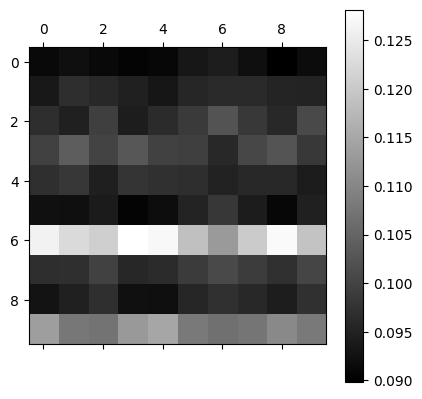

In [200]:
import matplotlib.pyplot as plt

x = torch.rand(1, 10, 5)  # (batch_size, seq_lengh, n_features)
attention = AttentionBlock(5, 5)

attn_outputs, attn_weights = attention(x, x, x)
print('Tamanho da saída da atenção:', attn_outputs.shape)
print('Dimensão da matriz de atenção:', attn_weights.shape)

plt.matshow(attn_weights[0].detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

O código implementado pela classe `AttentionBlock` representa o que chamamos de uma **cabeça de atenção**. Tipicamente, utilizaremos múltiplas cabeças para capturar diferentes padrões da entrada, tendo como análogo a passagem de múltiplos filtros em uma camada convolucional quando trabalhamos com imagens!

Suponha que temos $H$ cabeças de atenção, onde a cabeça $h$ possui a seguinte formulação: $\mathbf{H_h} = \text{Attention}(\mathbf{Q_h}, \mathbf{K_h}, \mathbf{V_h})$. Então, a nossa saída será representada por $\mathbf{Y} = \text{concat}[\mathbf{H_1}, \mathbf{H_2}, \dots, \mathbf{H}_H]$. Como cada matriz $\mathbf{H}_h$ possui dimensão $N \times D_v$, a matriz final $\mathbf{Y}$ terá dimensão $N \times HD_v$. Para combinarmos as múltiplas interpretações e aplicarmos futuramente conexões residuais, precisaremos realizar uma múltiplicação da concatenação das cabeças por uma matriz $\mathbf{W}^{(o)}$, de dimensão $HD_v \times D$. Com isso, teremos que a saída do nosso mecanismo de atenção de múltiplas cabeças (*multi-head attention*) será: $\mathbf{Y} = \text{concat}[\mathbf{H_1}, \mathbf{H_2}, \dots, \mathbf{H}_H]\mathbf{W}^{(o)}$.

> Tipicamente, escolhemos $D_v = D / H$, de forma que a matriz concatenada tenha dimensão $N \times D$.

<div style="text-align: center;">
    <img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/mha_details.png?raw=true"/>
</div>

Vamos implementar essa ideia em Pytorch.

Utilizaremos o seguinte fluxo como referência, onde cada bloco *self-attention* é uma instância da classe `AttentionBlock` passando `q = k = v = x`.

<div style="text-align: center;">
    <img width=600 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/mha_scheme.png?raw=true"/>
</div>

In [202]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        assert d_model % nhead == 0, f'{nhead} must divide {d_model}'

        hidden_size = d_model // nhead
        self.Wo = nn.Linear(nhead * hidden_size, d_model)  # nhead * hidden_size == d_model! (faremos assim apenas pra ser mais didático)

        attention_blocks = []
        for i in range(nhead):
            attn_block = AttentionBlock(d_model, hidden_size)
            attention_blocks.append(attn_block)
            
        self.attention_blocks = nn.ModuleList(attention_blocks)

    def forward(self, q, k, v):
        attn_outputs = []
        attn_weights = []
        
        for attention in self.attention_blocks:
            attn_output, attn_weight = attention(q, k, v)
            attn_outputs.append(attn_output)
            attn_weights.append(attn_weight)

        attn_outputs = torch.cat(attn_outputs, dim=-1)
        attn_outputs = self.Wo(attn_outputs)

        return attn_outputs, attn_weights

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [203]:
x = torch.rand(1, 10, 40)  # (batch_size, seq_lengh, n_features)
mha = MultiHeadAttention(40, 4)

attn_outputs, attn_weights = mha(x, x, x)
print('Tamanho da saída da atenção:', attn_outputs.shape)
print('Número de matrizes de atenção:', len(attn_weights))
print('Dimensão de uma matriz de atenção:', attn_weights[0].shape)

Tamanho da saída da atenção: torch.Size([1, 10, 40])
Número de matrizes de atenção: 4
Dimensão de uma matriz de atenção: torch.Size([1, 10, 10])


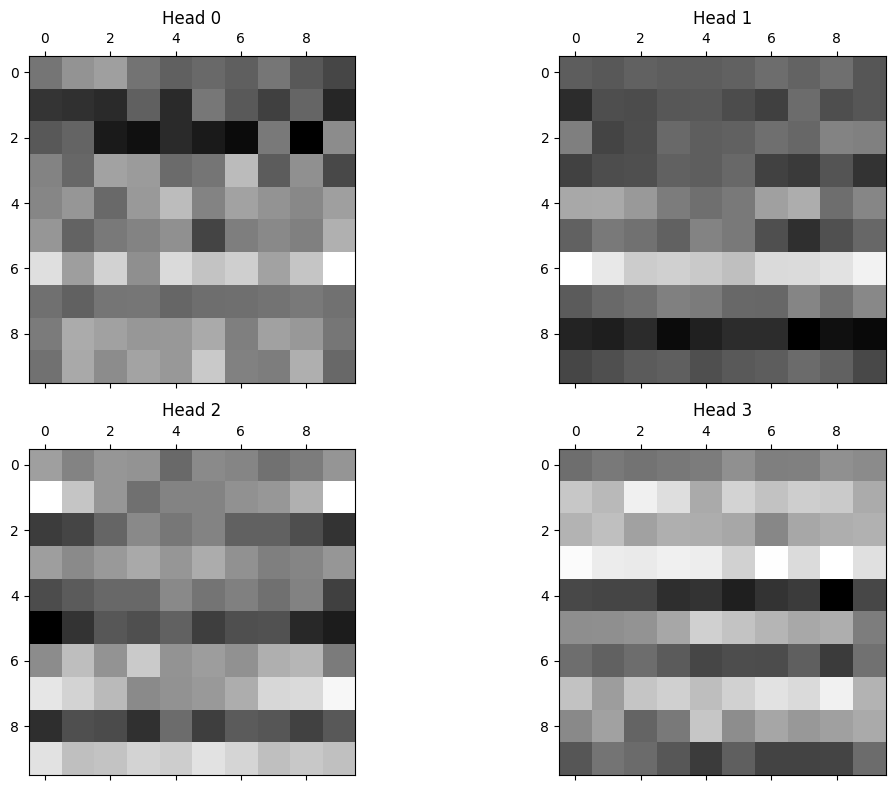

In [205]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

counter = 0
for i in range(2):
    for j in range(2):
        axs[i, j].set_title(f'Head {counter}')
        axs[i,j].matshow(attn_weights[counter][0].detach().numpy(), cmap='gray')
        counter += 1

fig.tight_layout()

### Construção de uma camada do *Transformer*

Entendendo o que um bloco de *multi-head attention* faz, conseguimos prosseguir na construção da camada de um *Transformer*. Após a aplicação de um mecanismo de atenção, iremos realizar um *batch normalization* da saída do mecanismo juntamente com a adição da sua entrada, tendo assim uma conexão residual da seguinte forma, onde simplificaremos a notação de *self-attention* como sendo $\text{MHA}(\mathbf{X})$:

$$
\mathbf{Z} = \text{LayerNorm}[\text{MHA}(\mathbf{X}) + \mathbf{X}]
$$

- Há a opção de também aplicarmos uma camada de *batch normalization* antes de computarmos a atenção da entrada da camada, já que isso pode resultar em uma otimização mais efetiva, ficando da seguinte forma: $\mathbf{Z} = \text{MHA}(\text{LayerNorm}[\mathbf{X}]) + \mathbf{X}$.

Note que até então, todas as operações feitas pela camada do nosso *Transformer* são operações lineares, cujas saídas residem no subespaço vetorial definido pelos vetores de entrada, limitando a capacidade de expressividade da nossa rede. Para lidar com isso, podemos introduzir uma sequência de camadas não-lineares após o cálculo de $\mathbf{Z}$. Em outras palavras, podemos pós-processar a saída da nossa camada de atenção através de uma rede MLP (*multilayer perceptron*) da seguinte forma (note que ainda trabalharemos com conexões residuais e *batch normalization*):

$$
\mathbf{\tilde{X}} = \text{LayerNorm}[\text{MLP}(\mathbf{Z}) + \mathbf{Z}]
$$

- Aqui também temos a opção de aplicar a camada de normalização antes de pós-processarmos o vetor $\mathbf{Z}$, ficando da seguinte forma: $\mathbf{\tilde{X}} = \text{MLP}(\text{LayerNorm}[\mathbf{Z}]) + \mathbf{Z}$.


Com isso, concluímos os componentes fundamentais de uma camada da arquitetura *Transformers*. Uma sumarização de todos esses passos pode ser vista através do seguinte esquema.

<div style="text-align: center;">
    <img width=250 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/transformers/transformer_layer_scheme.png?raw=true"/>
</div>

Vamos implementar essa ideia em PyTorch agora.

In [81]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, norm_first):
        """
        Implementação de uma cada da arquitetura Transformers.

        Argumentos
        ----------
            d_model (int): dimensão do vetor de entrada
            nhead (int): número de cabeças de atenção
            dim_feedforward (int): tamanho do estado oculto da MLP
            norm_first (bool): flag indicando se queremos aplicar batch normalization antes ou depois das operações
        """
        super().__init__()

        self.norm_first = norm_first
        self.norm1 = nn.BatchNorm1d(d_model)
        self.norm2 = nn.BatchNorm1d(d_model)
        self.mha = MultiHeadAttention(d_model, nhead)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, x):
        if self.norm_first:
            x_norm = self.apply_batch_norm(x, self.norm1)
            attn_outputs, attn_weights = self.mha(x_norm, x_norm, x_norm)
            z = attn_outputs + x

            z_norm = self.apply_batch_norm(z, self.norm2)
            outputs = self.mlp(z_norm) + z
        else:
            attn_outputs, attn_weights = self.mha(x, x, x)
            z = self.apply_batch_norm(attn_outputs + x, self.norm1)
            outputs = self.apply_batch_norm(self.mlp(z) + z, self.norm2)

        return outputs, attn_weights
    
    def apply_batch_norm(self, x, norm_layer):
        x = x.transpose(1, 2)  # batch norm espera dimensões (batch_size, n_features, seq_length)
        x = norm_layer(x)
        x = x.transpose(1, 2)  # camadas futuras esperam (batch_size, seq_length, n_features)

        return x

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [206]:
x = torch.rand(1, 10, 512)  # (batch_size, seq_lengh, n_features)
layer = TransformerLayer(d_model=512, nhead=8, dim_feedforward=2048, norm_first=False)

outputs, attn_weights = layer(x)
print('Tamanho da saída da camada:', outputs.shape)
print('Número de matrizes de atenção:', len(attn_weights))
print('Dimensão de uma matriz de atenção:', attn_weights[0].shape)

Tamanho da saída da camada: torch.Size([1, 10, 512])
Número de matrizes de atenção: 8
Dimensão de uma matriz de atenção: torch.Size([1, 10, 10])


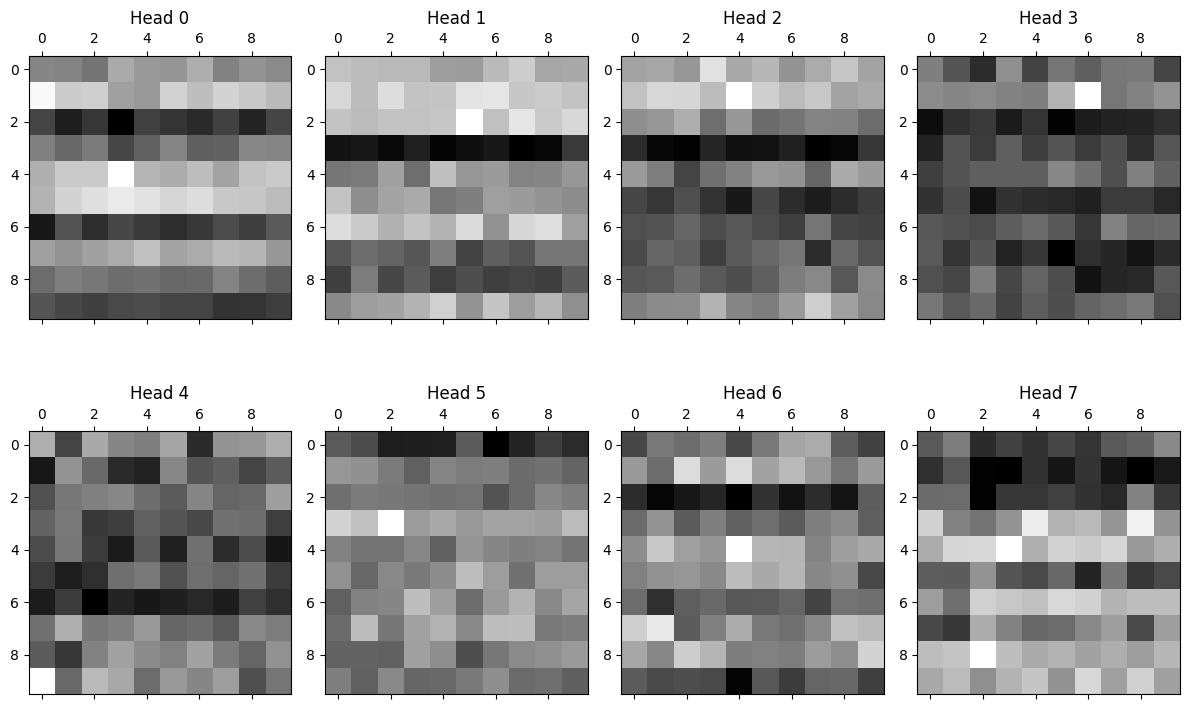

In [207]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8))

counter = 0
for i in range(2):
    for j in range(4):
        axs[i, j].set_title(f'Head {counter}')
        axs[i,j].matshow(attn_weights[counter][0].detach().numpy(), cmap='gray')
        counter += 1

fig.tight_layout()

### Positional encoding

Na arquitetura de um *Transformer*, as matrizes $\mathbf{W_h^{(q)}}$, $\mathbf{W_h^{(k)}}$, $\mathbf{W_h^{(v)}}$ são compartilhadas pelos *tokens* de entrada, assim como o restante da rede. Sendo assim, um *Transformer* é **equivariante** à permutações da entrada! As frases em inglês: *The food was bad, not good at all* e *The food was good, not bad at all*, possuem as mesmas palavras, porém, possuem sentidos completamente diferentes.

Para solucionar esse problema, iremos adicionar ao *embedding* da nossa entrada uma noção de posição através de um *positional encoding*, em outras palavras, o nosso novo *embedding* para o n-ésimo token será: $\mathbf{\tilde{x}}_n = \mathbf{x}_n + \mathbf{p}_n$, sendo $\mathbf{x}_n$ o *embedding* original do n-ésimo *token* e $\mathbf{p}_n$ um vetor de mesma dimensão que possui uma informação da posição daquele *token* na entrada. Existem diversas formas de gerar o vetor $\mathbf{p}$_n, para mais discussões sobre essas diferentes estratégias, consulte o livro do [Bishop](https://www.bishopbook.com/).

Aqui, iremos utilizar uma técnica baseada em funções senoidais introduzida por *Vaswani et al.*, em 2017, no seu artigo [*Attention Is All You Need*](https://arxiv.org/pdf/1706.03762.pdf). Para uma da posição $n$, teremos um vetor de *position-encoding* $\mathbf{p}_n$ associado, tendo seus componentes construídos da seguinte forma:
$$
\mathbf{p}_n^{(i)} = 
\begin{cases}
   \sin{\left(\dfrac{n}{L^{i / D}}\right)}, & \text{ se } i \text{ for par (da forma } 2k \text{),} \\
   \cos{\left(\dfrac{n}{L^{(i-1) / D}}\right)}, & \text{ se } i \text{ for ímpar (da forma } 2k+1 \text{),} \\
\end{cases}
$$

   - No artigo original, temos que $L = 10000$ (escolhido de forma empírica).

Vamos implementar essa ideia em PyTorch.

In [129]:
import math

class PositionalEncoding(nn.Module):
    """ Código baseado de https://pytorch.org/tutorials/beginner/transformer_tutorial.html """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # fazendo com que "pe" seja um buffer (variável não treinável)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [208]:
x = torch.rand(1, 128, 512)
encoding = PositionalEncoding(d_model=512)

x = encoding(x)
print('Tamanho dos vetores depois do positional encoding:', x.shape)

Tamanho dos vetores depois do positional encoding: torch.Size([1, 128, 512])


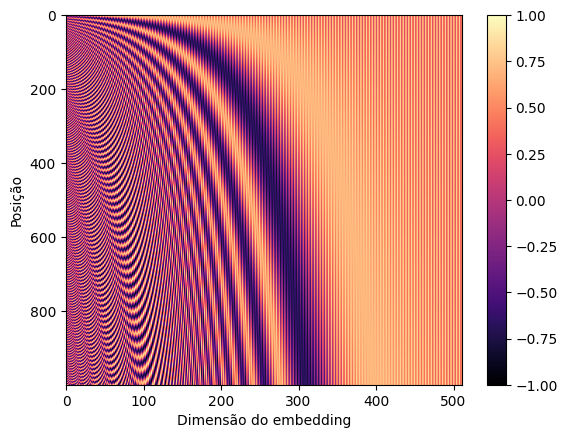

In [210]:
plt.imshow(encoding.pe[0, :1000], cmap='magma', aspect='auto')
plt.xlabel('Dimensão do embedding')
plt.ylabel('Posição')

plt.colorbar()
plt.show()

Finalmente, iremos juntar todos os bloquinhos desenvolvidos até então para criar um *Transformers* de múltiplas camadas.

> - O que estamos fazendo aqui na verdade é implementando os bloquinhos que fazem parte da etapa do *encoder* da arquitetura final, justificando assim o nome da classe ser `TransformerEncoder`.

In [179]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, nhead, dim_feedforward, norm_first, num_layers):
        super().__init__()
        
        self.pe = PositionalEncoding(d_model)
        self.embedding = nn.Linear(input_size, d_model)
        
        layers = []
        for i in range(num_layers):
            transformer_layer = TransformerLayer(d_model, nhead, dim_feedforward, norm_first)
            layers.append(transformer_layer)

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        attn_weights_per_layer = []
        outputs = self.pe(self.embedding(x))

        for layer in self.layers:
            outputs, attn_weights = layer(outputs)
            attn_weights_per_layer.append(attn_weights)

        return outputs, attn_weights_per_layer

Iremos criar um vetor aleatório de dados apenas para verificar se fizemos as contas de forma correta.

In [212]:
x = torch.rand(1, 10, 4)
encoder = TransformerEncoder(input_size=4, d_model=16, nhead=4,
                             dim_feedforward=64, norm_first=False, num_layers=2)

outputs, attn_weights = encoder(x)
print('Dimensão da saída:', outputs.shape)
print('Número de atenções de cada camada:', len(attn_weights[0]))
print('Dimensão das matrizes de atenção:', attn_weights[0][0].shape)

Dimensão da saída: torch.Size([1, 10, 16])
Número de atenções de cada camada: 4
Dimensão das matrizes de atenção: torch.Size([1, 10, 10])


## Exemplo prático: previsão de litologia utilizando *Transformers*

Para finalizar, iremos realizar um exemplo prático do que desenvolvemos até então em um contexto geológico através da previsão de litologia dado um conjunto de séries temporais como entrada. Para mais detalhes sobre os dados utilizados, bem como uma versão do mesmo exemplo utilizando LSTMs, consulte o seguinte [notebook](https://colab.research.google.com/drive/1PHgm0yveHSfFXt-ODtQ9_XFdqufN7qP6?usp=sharing#scrollTo=V9xCHeZxv_9c), desenvolvido pelo monitor João Pedro.

> - Iremos apenas carregar os dados de interesse e usar o mesmo pré-processamento discutido nesse outro notebook, logo não daremos muito foco para essas partes aqui.

In [159]:
import pandas as pd

datapath = '/pgeoprj/godeep/dados/l2_datasets/publico/force/train.csv'
df = pd.read_csv(datapath, sep=';')

print('Dimensão dos dados:', df.shape)
df.head()

Dimensão dos dados: (1170511, 29)


,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [160]:
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

wells = df['WELL'].unique()
print(f'Temos {len(wells)} poços únicos')

Temos 98 poços únicos


Visualização simples da distribuição de classes.

/tmp/ipykernel_940343/1997222706.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=45)


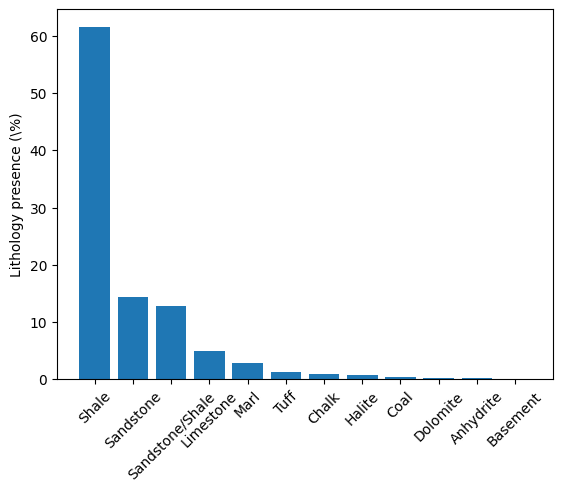

In [161]:
import numpy as np

names = []
percentage = []
counts = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

for item in counts.items():
    names.append(lithology_keys[item[0]])
    percentage.append(100 * float(item[1])/df.shape[0])

fig, ax = plt.subplots()
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

plt.show()

Visualização simples da distribuição de dados que podemos utilizar ao longo das *features*.

/tmp/ipykernel_940343/880137941.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.columns[2:-2], rotation=45)


Text(0, 0.5, 'Well presence (\\%)')

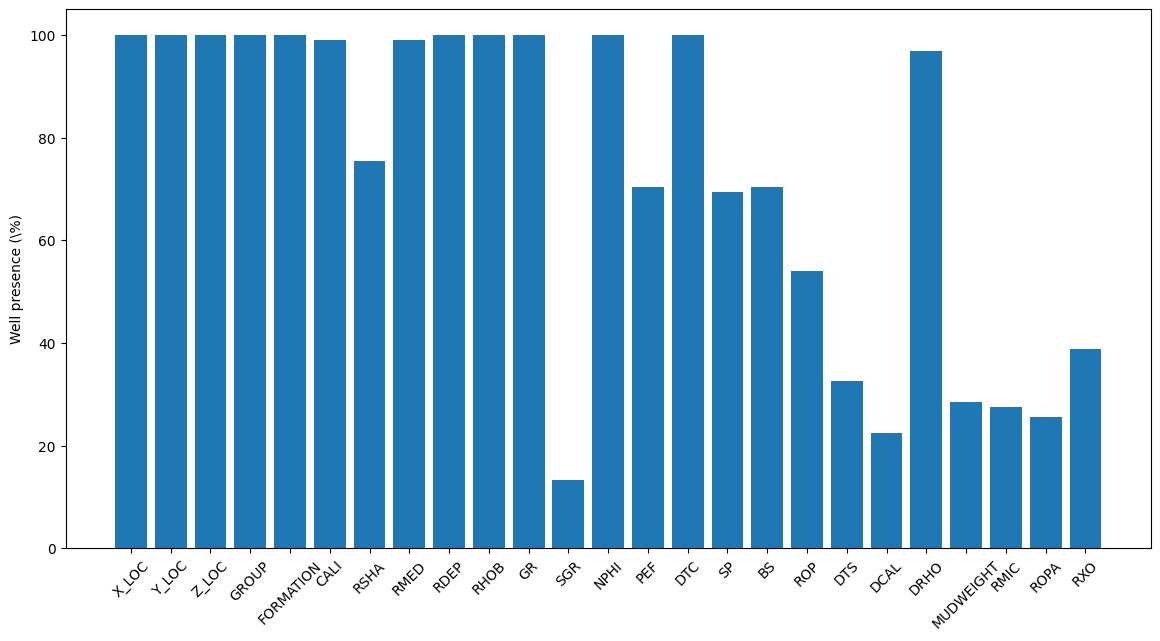

In [162]:
occurences = np.zeros(25)
for well in df['WELL'].unique():
    occurences += df[df['WELL'] == well].isna().all().astype(int).values[2:-2]
    
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(df.WELL.unique().shape[0]-occurences)/df.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(df.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

Visualização simples das *features* de interesse.

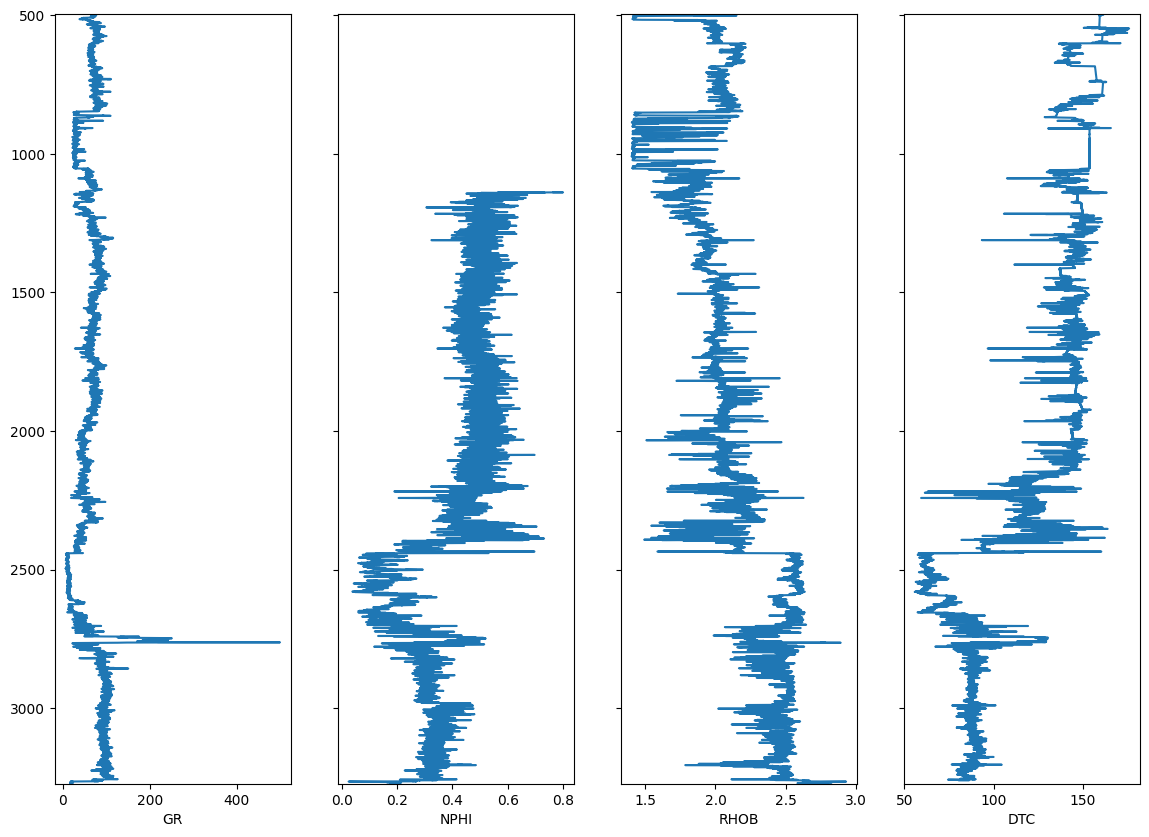

In [163]:
cols = ['GR', 'NPHI', 'RHOB', 'DTC']
well_data = df[df['WELL'] == wells[0]]

fig, axs = plt.subplots(1, len(cols), figsize=(14, 10), sharey=True)
for ic, col in enumerate(cols):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
    axs[ic].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

Filtragem dos dados de interesse e mapeamento de *features* para *label*.

In [169]:
lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}

interested = ['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY'] + cols
data = df[interested].copy()

data = data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY' : 'CLASS'})
data['CLASS'] = data['CLASS'].map(lithology_numbers)

data = data[['WELL', 'GR', 'NPHI', 'RHOB', 'DTC', 'CLASS']]
data = data.dropna()

print('Dimensão dos dados:', data.shape)
data.head()

Dimensão dos dados: (721358, 6)


,WELL,GR,NPHI,RHOB,DTC,CLASS
4238,15/9-13,55.892757,0.765867,1.774626,147.837677,0
4239,15/9-13,60.929138,0.800262,1.800986,142.382431,2
4240,15/9-13,62.117264,0.765957,1.817696,138.258331,2
4241,15/9-13,61.010860,0.702521,1.829333,139.198914,2
4242,15/9-13,58.501236,0.639708,1.813854,144.290085,2


In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721358 entries, 4238 to 1170446
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   WELL    721358 non-null  object 
 1   GR      721358 non-null  float64
 2   NPHI    721358 non-null  float64
 3   RHOB    721358 non-null  float64
 4   DTC     721358 non-null  float64
 5   CLASS   721358 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 38.5+ MB


Agrupamento dos dados por poço para evitar *vazamento de informação* entre conjuntos de dados.

(array([29., 19., 12., 11.,  8., 12.,  1.,  3.,  2.,  1.]),
 array([ 1538. ,  3679.1,  5820.2,  7961.3, 10102.4, 12243.5, 14384.6,
        16525.7, 18666.8, 20807.9, 22949. ]),
 <BarContainer object of 10 artists>)

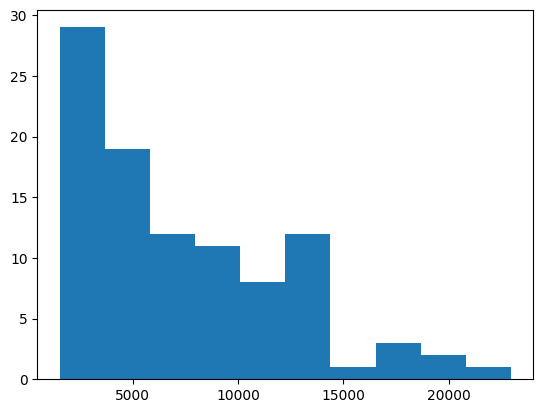

In [171]:
data_grouped = data.groupby('WELL')
wells_data = [data_grouped.get_group(x) for x in data_grouped.groups]

lens = [len(x) for x in wells_data]
plt.hist(lens)

In [172]:
from torch.utils.data import Dataset, DataLoader

class FORCE(Dataset):
    def __init__(self, dataframe):
        # Convert dataframe to NumPy array
        self.data_array = dataframe.drop(columns=['WELL']).values
        self.groups = dataframe['WELL'].values
        self.group_indices = self.compute_group_indices()

    def __len__(self):
        return len(self.group_indices)

    def __getitem__(self, idx):
        group_idx, data_idx = self.group_indices[idx]
        sequence_ = self.data_array[data_idx:data_idx+10]
        sequence = sequence_[:,:-1]
        label = sequence_[:,-1]

        sequence = (sequence - sequence.mean())/sequence.std()

        return torch.from_numpy(sequence).to(torch.float32), torch.from_numpy(label).to(torch.long)

    def compute_group_indices(self):
        unique_groups, group_counts = np.unique(self.groups, return_counts=True)
        group_indices = []
        start_idx = 0
        for group, count in zip(unique_groups, group_counts):
            end_idx = start_idx + count - 9
            indices = [(i, idx) for i, idx in enumerate(range(start_idx, end_idx))]
            group_indices.extend(indices)
            start_idx = end_idx
        return group_indices


dataset = FORCE(data)
print('Número de dados:', len(dataset))

Número de dados: 720476


In [174]:
X, y = dataset[0]
print('Dimensão das features:', X.shape)
print('Dimensão das anotações:', y.shape)

Dimensão das features: torch.Size([10, 4])
Dimensão das anotações: torch.Size([10])


### Treinamento do modelo sobre os dados da competição

In [213]:
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print('Utilizando:', device)

Utilizando: cuda


In [214]:
class LithologyModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, dim_feedforward, norm_first, num_layers):
        super().__init__()

        self.encoder = TransformerEncoder(input_size, d_model, nhead,
                                          dim_feedforward, norm_first, num_layers)
        
        self.classifier = nn.Linear(d_model, output_size)

    def forward(self, x):
        outputs, attn_weights = self.encoder(x)
        outputs = self.classifier(outputs)

        return outputs, attn_weights

In [215]:
import torch.optim as optim

batch_size = 1024
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LithologyModel(input_size=4, output_size=12, d_model=128, nhead=4,
                           dim_feedforward=512, norm_first=False, num_layers=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print('Número de parâmetros do nosso modelo:', n_params)

print('\nComponentes do modelo final:')
print(model)

Número de parâmetros do nosso modelo: 398732

Componentes do modelo final:
LithologyModel(
  (encoder): TransformerEncoder(
    (pe): PositionalEncoding()
    (embedding): Linear(in_features=4, out_features=128, bias=True)
    (layers): ModuleList(
      (0-1): 2 x TransformerLayer(
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mha): MultiHeadAttention(
          (Wo): Linear(in_features=128, out_features=128, bias=True)
          (attention_blocks): ModuleList(
            (0-3): 4 x AttentionBlock(
              (Wq): Linear(in_features=128, out_features=32, bias=True)
              (Wk): Linear(in_features=128, out_features=32, bias=True)
              (Wv): Linear(in_features=128, out_features=32, bias=True)
            )
          )
        )
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512,

In [218]:
from tqdm.notebook import tqdm

num_epochs = 25
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0

    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.to(device)
        y = y.to(device)

        outputs, attn_weights = model(X)

        optimizer.zero_grad()
        loss = criterion(outputs.transpose(1, 2), y)  # a loss function espera que a saída do modelo seja (batch_size, out_size, seq_lengh)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (batch + 1) % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Batch [{batch+1}/{len(dataloader)}] -> batch loss: {loss.item():.5f}')

    epoch_loss /= len(dataloader)
    print(f'Epoch [{epoch}/{num_epochs}] -> mean epoch loss: {epoch_loss:.5f}')

0it [00:00, ?it/s]

Epoch [1/25], Batch [100/704] -> batch loss: 1.16562
Epoch [1/25], Batch [200/704] -> batch loss: 0.95270
Epoch [1/25], Batch [300/704] -> batch loss: 0.91017
Epoch [1/25], Batch [400/704] -> batch loss: 0.95642
Epoch [1/25], Batch [500/704] -> batch loss: 0.88179
Epoch [1/25], Batch [600/704] -> batch loss: 0.95060
Epoch [1/25], Batch [700/704] -> batch loss: 0.88111
Epoch [1/25] -> mean epoch loss: 1.00049


0it [00:00, ?it/s]

Epoch [2/25], Batch [100/704] -> batch loss: 0.88054
Epoch [2/25], Batch [200/704] -> batch loss: 0.89616
Epoch [2/25], Batch [300/704] -> batch loss: 0.87293
Epoch [2/25], Batch [400/704] -> batch loss: 0.82754
Epoch [2/25], Batch [500/704] -> batch loss: 0.81456
Epoch [2/25], Batch [600/704] -> batch loss: 0.82407
Epoch [2/25], Batch [700/704] -> batch loss: 0.85165
Epoch [2/25] -> mean epoch loss: 0.87332


0it [00:00, ?it/s]

Epoch [3/25], Batch [100/704] -> batch loss: 0.86860
Epoch [3/25], Batch [200/704] -> batch loss: 0.86147
Epoch [3/25], Batch [300/704] -> batch loss: 0.86906
Epoch [3/25], Batch [400/704] -> batch loss: 0.87534
Epoch [3/25], Batch [500/704] -> batch loss: 0.85186
Epoch [3/25], Batch [600/704] -> batch loss: 0.83396
Epoch [3/25], Batch [700/704] -> batch loss: 0.81583
Epoch [3/25] -> mean epoch loss: 0.85544


0it [00:00, ?it/s]

Epoch [4/25], Batch [100/704] -> batch loss: 0.87758
Epoch [4/25], Batch [200/704] -> batch loss: 0.83773
Epoch [4/25], Batch [300/704] -> batch loss: 0.85007
Epoch [4/25], Batch [400/704] -> batch loss: 0.85445
Epoch [4/25], Batch [500/704] -> batch loss: 0.87298
Epoch [4/25], Batch [600/704] -> batch loss: 0.83704
Epoch [4/25], Batch [700/704] -> batch loss: 0.85137
Epoch [4/25] -> mean epoch loss: 0.84429


0it [00:00, ?it/s]

Epoch [5/25], Batch [100/704] -> batch loss: 0.81168
Epoch [5/25], Batch [200/704] -> batch loss: 0.85747
Epoch [5/25], Batch [300/704] -> batch loss: 0.82193
Epoch [5/25], Batch [400/704] -> batch loss: 0.84994
Epoch [5/25], Batch [500/704] -> batch loss: 0.82851
Epoch [5/25], Batch [600/704] -> batch loss: 0.82681
Epoch [5/25], Batch [700/704] -> batch loss: 0.85712
Epoch [5/25] -> mean epoch loss: 0.83525


0it [00:00, ?it/s]

Epoch [6/25], Batch [100/704] -> batch loss: 0.85669
Epoch [6/25], Batch [200/704] -> batch loss: 0.87581
Epoch [6/25], Batch [300/704] -> batch loss: 0.82769
Epoch [6/25], Batch [400/704] -> batch loss: 0.76481
Epoch [6/25], Batch [500/704] -> batch loss: 0.81588
Epoch [6/25], Batch [600/704] -> batch loss: 0.83028
Epoch [6/25], Batch [700/704] -> batch loss: 0.81227
Epoch [6/25] -> mean epoch loss: 0.82730


0it [00:00, ?it/s]

Epoch [7/25], Batch [100/704] -> batch loss: 0.80789
Epoch [7/25], Batch [200/704] -> batch loss: 0.79441
Epoch [7/25], Batch [300/704] -> batch loss: 0.90859
Epoch [7/25], Batch [400/704] -> batch loss: 0.80151
Epoch [7/25], Batch [500/704] -> batch loss: 0.77521
Epoch [7/25], Batch [600/704] -> batch loss: 0.76264
Epoch [7/25], Batch [700/704] -> batch loss: 0.88046
Epoch [7/25] -> mean epoch loss: 0.82040


0it [00:00, ?it/s]

Epoch [8/25], Batch [100/704] -> batch loss: 0.82245
Epoch [8/25], Batch [200/704] -> batch loss: 0.83774
Epoch [8/25], Batch [300/704] -> batch loss: 0.76221
Epoch [8/25], Batch [400/704] -> batch loss: 0.83059
Epoch [8/25], Batch [500/704] -> batch loss: 0.79952
Epoch [8/25], Batch [600/704] -> batch loss: 0.82968
Epoch [8/25], Batch [700/704] -> batch loss: 0.78384
Epoch [8/25] -> mean epoch loss: 0.81257


0it [00:00, ?it/s]

Epoch [9/25], Batch [100/704] -> batch loss: 0.76603
Epoch [9/25], Batch [200/704] -> batch loss: 0.81801
Epoch [9/25], Batch [300/704] -> batch loss: 0.77785
Epoch [9/25], Batch [400/704] -> batch loss: 0.83941
Epoch [9/25], Batch [500/704] -> batch loss: 0.81729
Epoch [9/25], Batch [600/704] -> batch loss: 0.86021
Epoch [9/25], Batch [700/704] -> batch loss: 0.87430
Epoch [9/25] -> mean epoch loss: 0.80615


0it [00:00, ?it/s]

Epoch [10/25], Batch [100/704] -> batch loss: 0.76067
Epoch [10/25], Batch [200/704] -> batch loss: 0.81367
Epoch [10/25], Batch [300/704] -> batch loss: 0.76642
Epoch [10/25], Batch [400/704] -> batch loss: 0.85476
Epoch [10/25], Batch [500/704] -> batch loss: 0.75788
Epoch [10/25], Batch [600/704] -> batch loss: 0.76714
Epoch [10/25], Batch [700/704] -> batch loss: 0.75399
Epoch [10/25] -> mean epoch loss: 0.79784


0it [00:00, ?it/s]

Epoch [11/25], Batch [100/704] -> batch loss: 0.80828
Epoch [11/25], Batch [200/704] -> batch loss: 0.80695
Epoch [11/25], Batch [300/704] -> batch loss: 0.74821
Epoch [11/25], Batch [400/704] -> batch loss: 0.77361
Epoch [11/25], Batch [500/704] -> batch loss: 0.75506
Epoch [11/25], Batch [600/704] -> batch loss: 0.79490
Epoch [11/25], Batch [700/704] -> batch loss: 0.80163
Epoch [11/25] -> mean epoch loss: 0.78971


0it [00:00, ?it/s]

Epoch [12/25], Batch [100/704] -> batch loss: 0.75498
Epoch [12/25], Batch [200/704] -> batch loss: 0.77182
Epoch [12/25], Batch [300/704] -> batch loss: 0.78068
Epoch [12/25], Batch [400/704] -> batch loss: 0.80765
Epoch [12/25], Batch [500/704] -> batch loss: 0.83701
Epoch [12/25], Batch [600/704] -> batch loss: 0.77198
Epoch [12/25], Batch [700/704] -> batch loss: 0.76690
Epoch [12/25] -> mean epoch loss: 0.78010


0it [00:00, ?it/s]

Epoch [13/25], Batch [100/704] -> batch loss: 0.75031
Epoch [13/25], Batch [200/704] -> batch loss: 0.79004
Epoch [13/25], Batch [300/704] -> batch loss: 0.75413
Epoch [13/25], Batch [400/704] -> batch loss: 0.76206
Epoch [13/25], Batch [500/704] -> batch loss: 0.77878
Epoch [13/25], Batch [600/704] -> batch loss: 0.77710
Epoch [13/25], Batch [700/704] -> batch loss: 0.81712
Epoch [13/25] -> mean epoch loss: 0.77386


0it [00:00, ?it/s]

Epoch [14/25], Batch [100/704] -> batch loss: 0.78857
Epoch [14/25], Batch [200/704] -> batch loss: 0.75669
Epoch [14/25], Batch [300/704] -> batch loss: 0.79888
Epoch [14/25], Batch [400/704] -> batch loss: 0.74097
Epoch [14/25], Batch [500/704] -> batch loss: 0.78774
Epoch [14/25], Batch [600/704] -> batch loss: 0.74482
Epoch [14/25], Batch [700/704] -> batch loss: 0.78277
Epoch [14/25] -> mean epoch loss: 0.76737


0it [00:00, ?it/s]

Epoch [15/25], Batch [100/704] -> batch loss: 0.77263
Epoch [15/25], Batch [200/704] -> batch loss: 0.76560
Epoch [15/25], Batch [300/704] -> batch loss: 0.77838
Epoch [15/25], Batch [400/704] -> batch loss: 0.78738
Epoch [15/25], Batch [500/704] -> batch loss: 0.75790
Epoch [15/25], Batch [600/704] -> batch loss: 0.70763
Epoch [15/25], Batch [700/704] -> batch loss: 0.75181
Epoch [15/25] -> mean epoch loss: 0.76137


0it [00:00, ?it/s]

Epoch [16/25], Batch [100/704] -> batch loss: 0.75847
Epoch [16/25], Batch [200/704] -> batch loss: 0.73050
Epoch [16/25], Batch [300/704] -> batch loss: 0.79816
Epoch [16/25], Batch [400/704] -> batch loss: 0.76600
Epoch [16/25], Batch [500/704] -> batch loss: 0.76887
Epoch [16/25], Batch [600/704] -> batch loss: 0.70082
Epoch [16/25], Batch [700/704] -> batch loss: 0.73097
Epoch [16/25] -> mean epoch loss: 0.75365


0it [00:00, ?it/s]

Epoch [17/25], Batch [100/704] -> batch loss: 0.75816
Epoch [17/25], Batch [200/704] -> batch loss: 0.71206
Epoch [17/25], Batch [300/704] -> batch loss: 0.74533
Epoch [17/25], Batch [400/704] -> batch loss: 0.74932
Epoch [17/25], Batch [500/704] -> batch loss: 0.72814
Epoch [17/25], Batch [600/704] -> batch loss: 0.75282
Epoch [17/25], Batch [700/704] -> batch loss: 0.74647
Epoch [17/25] -> mean epoch loss: 0.74713


0it [00:00, ?it/s]

Epoch [18/25], Batch [100/704] -> batch loss: 0.73852
Epoch [18/25], Batch [200/704] -> batch loss: 0.73088
Epoch [18/25], Batch [300/704] -> batch loss: 0.74032
Epoch [18/25], Batch [400/704] -> batch loss: 0.74706
Epoch [18/25], Batch [500/704] -> batch loss: 0.76231
Epoch [18/25], Batch [600/704] -> batch loss: 0.74390
Epoch [18/25], Batch [700/704] -> batch loss: 0.75135
Epoch [18/25] -> mean epoch loss: 0.73937


0it [00:00, ?it/s]

Epoch [19/25], Batch [100/704] -> batch loss: 0.76194
Epoch [19/25], Batch [200/704] -> batch loss: 0.67558
Epoch [19/25], Batch [300/704] -> batch loss: 0.70526
Epoch [19/25], Batch [400/704] -> batch loss: 0.71391
Epoch [19/25], Batch [500/704] -> batch loss: 0.71164
Epoch [19/25], Batch [600/704] -> batch loss: 0.74860
Epoch [19/25], Batch [700/704] -> batch loss: 0.76348
Epoch [19/25] -> mean epoch loss: 0.73163


0it [00:00, ?it/s]

Epoch [20/25], Batch [100/704] -> batch loss: 0.76723
Epoch [20/25], Batch [200/704] -> batch loss: 0.73094
Epoch [20/25], Batch [300/704] -> batch loss: 0.71231
Epoch [20/25], Batch [400/704] -> batch loss: 0.72917
Epoch [20/25], Batch [500/704] -> batch loss: 0.75000
Epoch [20/25], Batch [600/704] -> batch loss: 0.73878
Epoch [20/25], Batch [700/704] -> batch loss: 0.73228
Epoch [20/25] -> mean epoch loss: 0.72605


0it [00:00, ?it/s]

Epoch [21/25], Batch [100/704] -> batch loss: 0.73215
Epoch [21/25], Batch [200/704] -> batch loss: 0.69489
Epoch [21/25], Batch [300/704] -> batch loss: 0.73499
Epoch [21/25], Batch [400/704] -> batch loss: 0.70079
Epoch [21/25], Batch [500/704] -> batch loss: 0.73664
Epoch [21/25], Batch [600/704] -> batch loss: 0.70735
Epoch [21/25], Batch [700/704] -> batch loss: 0.71687
Epoch [21/25] -> mean epoch loss: 0.71984


0it [00:00, ?it/s]

Epoch [22/25], Batch [100/704] -> batch loss: 0.68323
Epoch [22/25], Batch [200/704] -> batch loss: 0.72352
Epoch [22/25], Batch [300/704] -> batch loss: 0.67062
Epoch [22/25], Batch [400/704] -> batch loss: 0.70733
Epoch [22/25], Batch [500/704] -> batch loss: 0.72185
Epoch [22/25], Batch [600/704] -> batch loss: 0.69680
Epoch [22/25], Batch [700/704] -> batch loss: 0.69977
Epoch [22/25] -> mean epoch loss: 0.71396


0it [00:00, ?it/s]

Epoch [23/25], Batch [100/704] -> batch loss: 0.71126
Epoch [23/25], Batch [200/704] -> batch loss: 0.70131
Epoch [23/25], Batch [300/704] -> batch loss: 0.71300
Epoch [23/25], Batch [400/704] -> batch loss: 0.67710
Epoch [23/25], Batch [500/704] -> batch loss: 0.72295
Epoch [23/25], Batch [600/704] -> batch loss: 0.70113
Epoch [23/25], Batch [700/704] -> batch loss: 0.66428
Epoch [23/25] -> mean epoch loss: 0.70947


0it [00:00, ?it/s]

Epoch [24/25], Batch [100/704] -> batch loss: 0.69756
Epoch [24/25], Batch [200/704] -> batch loss: 0.73172
Epoch [24/25], Batch [300/704] -> batch loss: 0.74721
Epoch [24/25], Batch [400/704] -> batch loss: 0.66638
Epoch [24/25], Batch [500/704] -> batch loss: 0.71323
Epoch [24/25], Batch [600/704] -> batch loss: 0.69216
Epoch [24/25], Batch [700/704] -> batch loss: 0.64519
Epoch [24/25] -> mean epoch loss: 0.70437


0it [00:00, ?it/s]

Epoch [25/25], Batch [100/704] -> batch loss: 0.74107
Epoch [25/25], Batch [200/704] -> batch loss: 0.71574
Epoch [25/25], Batch [300/704] -> batch loss: 0.73284
Epoch [25/25], Batch [400/704] -> batch loss: 0.68402
Epoch [25/25], Batch [500/704] -> batch loss: 0.69381
Epoch [25/25], Batch [600/704] -> batch loss: 0.71005
Epoch [25/25], Batch [700/704] -> batch loss: 0.67245
Epoch [25/25] -> mean epoch loss: 0.70017
